In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install line-profiler

   ---------------------------------------- 0.0/128.3 kB ? eta -:--:--
   ------------------- -------------------- 61.4/128.3 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 128.3/128.3 kB 2.5 MB/s eta 0:00:00


In [3]:
import cProfile

# Problem 1

## Loading Datasets

In [6]:
train = pd.read_csv('healthcareTrain.csv')
test = pd.read_csv('healthcareTest.csv')

In [7]:
train.columns

Index(['patIndex', 'pdc', 'num_ip_post', 'total_los_post', 'num_op_post',
       'num_er_post', 'num_ndc_post', 'num_gpi6_post', 'adjust_total_30d_post',
       'generic_rate_post', 'post_ip_flag', 'post_er_flag', 'pdc_cat',
       'post_ip_cost', 'post_er_cost', 'post_rx_cost', 'post_op_cost',
       'post_total_cost', 'post_medical_cost', 'idx_copay', 'age_grpN', 'sexN',
       'regionN', 'idx_prodtypeN', 'idx_paytypN', 'age_cat', 'log_idx_copay',
       'ALCOHOL_DRUG', 'ASTHMA', 'CARDIAC_ARRYTHMIA', 'CARDIAC_VALVULAR',
       'CEREBROVASCULAR', 'CHRONIC_KIDNEY', 'CHRONIC_PAIN_FIBRO', 'CHF',
       'COPD', 'DEMENTIA', 'DEPRESSION', 'DIABETES', 'DYSLIPIDEMIA',
       'EPILEPSY_SEIZURE', 'HEPATITIS', 'HIV_AIDS', 'HYPERTENSION',
       'LIVER_GALLBLADDER_PANCREAS', 'MI_CAD', 'OSTEOARTHRITIS', 'PARALYSIS',
       'PEPTIC_ULCER', 'PERIPHERAL_VASCULAR', 'RENAL_FAILURE', 'RHEUMATOLOGIC',
       'SCHIZOPHRENIA', 'SLEEP_DISORDERS', 'SMOKING', 'THYROID', 'Solid_Tumor',
       'Metastatic', 'Le

In [8]:
features = ['total_los','num_op','num_er','num_ndc','pre_total_cost','pre_CCI']

## Checking and Solving Missing Values

In [10]:
print(train[features].isnull().sum())

total_los         0
num_op            0
num_er            0
num_ndc           0
pre_total_cost    0
pre_CCI           0
dtype: int64


In [11]:
print(train['pdc_80_flag'].isnull().sum())

0


In [12]:
print(test[features].isnull().sum())

total_los         0
num_op            0
num_er            0
num_ndc           0
pre_total_cost    0
pre_CCI           0
dtype: int64


In [13]:
print(test['pdc_80_flag'].isnull().sum())

0


## Normalizing/Standardizing Datasets (If Need)

In [15]:
print(train[features].describe())

         total_los       num_op       num_er      num_ndc  pre_total_cost  \
count  1378.000000  1378.000000  1378.000000  1378.000000     1378.000000   
mean      0.386067     6.258345     0.245283    12.615385     5137.492252   
std       1.769304     8.076973     0.625699    11.797189    10278.008826   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.000000     2.000000     0.000000     4.000000      784.549932   
50%       0.000000     4.000000     0.000000     9.000000     1974.442045   
75%       0.000000     8.000000     0.000000    18.000000     4633.353826   
max      25.000000   180.000000     8.000000    82.000000   103510.802200   

           pre_CCI  
count  1378.000000  
mean      1.042816  
std       1.155478  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max      10.000000  


In [16]:
print(test[features].describe())

        total_los      num_op      num_er     num_ndc  pre_total_cost  \
count  344.000000  344.000000  344.000000  344.000000      344.000000   
mean     0.485465    6.462209    0.299419   10.802326     5040.464796   
std      2.786853    7.363037    0.840241   10.732442     9791.459769   
min      0.000000    0.000000    0.000000    0.000000        0.000000   
25%      0.000000    2.000000    0.000000    3.000000      850.720970   
50%      0.000000    4.000000    0.000000    8.000000     1997.317788   
75%      0.000000    8.000000    0.000000   15.000000     4509.738902   
max     34.000000   55.000000    7.000000   67.000000    80441.174770   

          pre_CCI  
count  344.000000  
mean     1.031977  
std      1.188684  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      1.000000  
max      8.000000  


Some features have values in the hundreds or thousands (e.g., total_cost_post, brand_cost_post) and others have values close to zero (e.g., generic_rate_post, ratio_g_total_cost). So they have a large range among values

=> We should normalize/standardize

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(train[features]), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(test[features]), columns=features)

## Implement 10-Fold Cross-Validation

In [22]:
k_values = list(range(31, 102, 2))

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [24]:
X_train = train[features]
y_train = train['pdc_80_flag']

In [25]:
from sklearn.metrics import mean_squared_error

Reference for k-fold cross validation : https://www.analyticsvidhya.com/blog/2022/02/k-fold-cross-validation-technique-and-its-essentials/#:~:text=K%2Dfold%20cross%20validation%20in%20machine%20learning%20cross%2Dvalidation%20is,folds%20are%20used%20for%20training.

In [27]:
def generate_folds(n_samples, n_folds, random_state=42):
    """
    Generate a list of index arrays for each fold.

    Parameters:
        n_samples : int
            Total number of samples in the dataset.
        n_folds : int
            Number of folds to generate.
        random_state : int
            Seed for reproducibility.

    Returns:
        folds : list of numpy arrays
            List where each element is an array of indices for that fold.
    """
    np.random.seed(random_state)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # Fix: Shuffle before partitioning
    fold_sizes = np.full(n_folds, n_samples // n_folds, dtype=int)
    fold_sizes[:n_samples % n_folds] += 1  # Distribute remainder
    folds = []
    current = 0
    for fold_size in fold_sizes:
        folds.append(indices[current:current + fold_size])
        current += fold_size
    return folds

In [28]:
from line_profiler import LineProfiler


In [29]:
def cross_validate_knn(X, y, k_values, n_folds=10):
    """
    Perform k-fold cross-validation manually for KNN without using KFold.

    Parameters:
        X : pandas DataFrame
            Feature matrix.
        y : pandas Series or array-like
            Target vector.
        k_values : list or iterable of int
            List of k values (number of neighbors) to evaluate.
        n_folds : int, default=10
            Number of folds for cross-validation.

    Returns:
        results : dict
            Dictionary mapping each k value to the average accuracy over all folds.
    """
    n_samples = len(X)
    folds = generate_folds(n_samples, n_folds, random_state=42)
    results = {}

    for k in k_values:
        accuracy_scores = []

        # Iterate over each fold as the validation set
        for i in range(n_folds):
            val_indices = folds[i]
            # Use all other folds as the training set
            train_indices = np.concatenate([folds[j] for j in range(n_folds) if j != i])

            X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
            y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            accuracy_scores.append(accuracy)

        results[k] = np.mean(accuracy_scores)

    return results

# Example usage:
# k_values = list(range(31, 102, 2))
# cv_results = cross_validate_knn(X_train, y_train, k_values)
# for k, acc in cv_results.items():
#     print(f"k = {k}: Average Accuracy = {acc*100:.2f}%")


In [30]:
# Create a LineProfiler instance
lp = LineProfiler()
lp.add_function(cross_validate_knn)  # Profile this function
lp.add_function(generate_folds)  # Profile the generate_folds function inside it

In [31]:
lp.enable()  # Start profiling
cv_results = cross_validate_knn(X_train, y_train, k_values)
# lp.disable()  # Stop profiling

# lp.print_stats()  # Print the profiling results

In [32]:
# Convert accuracy values to percentages
cv_results_percent = {k: round(v * 100, 2) for k, v in cv_results.items()}

# Print results with percentage formatting
for k, acc in cv_results_percent.items():
    print(f"k={k}: {acc}%")

k=31: 59.44%
k=33: 60.24%
k=35: 59.73%
k=37: 59.22%
k=39: 58.71%
k=41: 59.51%
k=43: 60.6%
k=45: 60.31%
k=47: 59.94%
k=49: 60.02%
k=51: 60.38%
k=53: 60.23%
k=55: 60.24%
k=57: 60.38%
k=59: 60.96%
k=61: 60.67%
k=63: 60.38%
k=65: 59.73%
k=67: 59.44%
k=69: 59.58%
k=71: 59.87%
k=73: 59.66%
k=75: 59.51%
k=77: 59.44%
k=79: 59.66%
k=81: 59.58%
k=83: 59.73%
k=85: 59.73%
k=87: 59.73%
k=89: 59.87%
k=91: 60.09%
k=93: 59.95%
k=95: 59.95%
k=97: 60.16%
k=99: 59.88%
k=101: 59.95%


In [33]:
# lp.enable()
cv_scaled_results = cross_validate_knn(X_train_scaled, y_train, k_values)
# lp.disable()

# lp.print_stats()

In [34]:
# Convert accuracy values to percentages
cv_scaled_results_percent = {k: round(v * 100, 2) for k, v in cv_scaled_results.items()}

# Print results with percentage formatting
for k, acc in cv_scaled_results_percent.items():
    print(f"k={k}: {acc}%")

k=31: 60.01%
k=33: 60.08%
k=35: 59.36%
k=37: 59.72%
k=39: 59.94%
k=41: 59.94%
k=43: 59.65%
k=45: 59.36%
k=47: 60.16%
k=49: 59.58%
k=51: 58.85%
k=53: 58.85%
k=55: 58.56%
k=57: 59.0%
k=59: 59.07%
k=61: 58.63%
k=63: 58.78%
k=65: 58.71%
k=67: 59.5%
k=69: 59.28%
k=71: 59.28%
k=73: 59.22%
k=75: 59.65%
k=77: 59.65%
k=79: 59.22%
k=81: 59.51%
k=83: 59.36%
k=85: 60.23%
k=87: 59.29%
k=89: 59.07%
k=91: 58.92%
k=93: 58.93%
k=95: 58.85%
k=97: 59.07%
k=99: 59.0%
k=101: 58.49%


## Find the Best K

In [36]:
best_k = max(cv_results, key=cv_results.get)
print("Best K:", best_k)
print(f"Best Validation Accuracy:{cv_results[best_k] * 100:.2f}%")

Best K: 59
Best Validation Accuracy:60.96%


In [37]:
best_scaled_k = max(cv_scaled_results, key=cv_scaled_results.get)
print("Best K:", best_scaled_k)
print(f"Best Validation Accuracy (With Normalization/Standardization):{cv_scaled_results[best_k] * 100:.2f}%")

Best K: 85
Best Validation Accuracy (With Normalization/Standardization):59.07%


## Plot Accuracy vs K


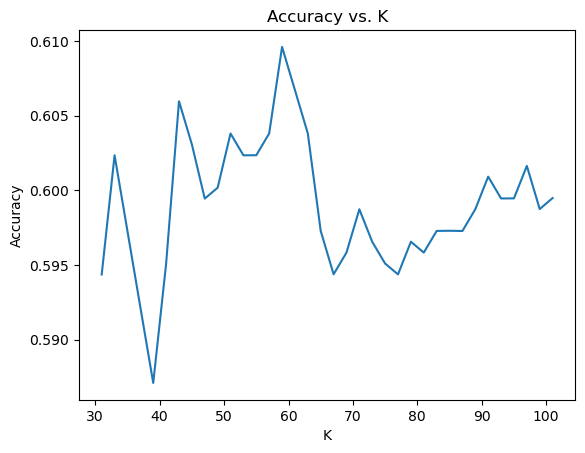

In [39]:
# Plotting accuracy vs. K values
plt.plot(list(cv_results.keys()), list(cv_results.values()))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K')
plt.show()

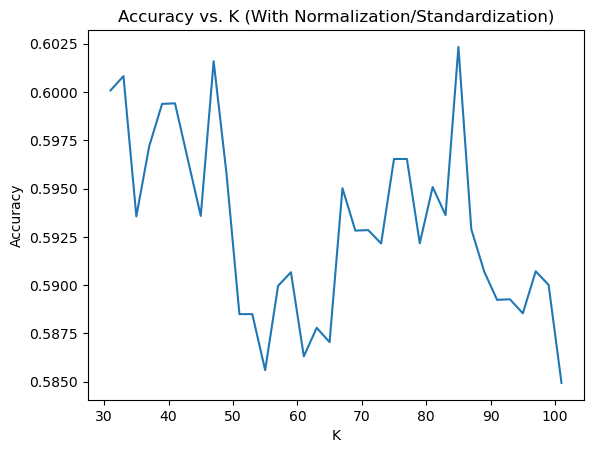

In [40]:
# Plotting accuracy vs. K values
plt.plot(list(cv_scaled_results.keys()), list(cv_scaled_results.values()))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K (With Normalization/Standardization)')
plt.show()

## Train Final Model and Evaluate on Test Set

In [42]:
X_test = test[features]
y_test = test['pdc_80_flag']

In [43]:
test_knn = KNeighborsClassifier(n_neighbors = best_k)
test_knn.fit(X_train, y_train)
y_pred_test = test_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 58.14%


In [44]:
test_scaled_knn = KNeighborsClassifier(n_neighbors = best_k)
test_scaled_knn.fit(X_train_scaled, y_train)
y_pred_scaled_test = test_knn.predict(X_test_scaled)
test_scaled_accuracy = accuracy_score(y_test, y_pred_scaled_test)
print(f"Test Accuracy (With Normalization/Standardization): {test_scaled_accuracy * 100:.2f}%")

Test Accuracy (With Normalization/Standardization): 62.50%


## Compare Validation and Test Error

In [46]:
validation_error = 1 - cv_results[best_k]
print(f"Validation Error: {validation_error * 100:.2f}%")

Validation Error: 39.04%


In [47]:
validation_error = 1 - cv_scaled_results[best_k]
print(f"Validation Error (With Normalization/Standardization): {validation_error * 100:.2f}%")

Validation Error (With Normalization/Standardization): 40.93%


In [48]:
# test_error = mean_squared_error(y_test, y_pred_test)
test_error = 1 - test_accuracy
print(f"Test Error:{test_error * 100:.2f}%")

Test Error:41.86%


In [49]:
test_error = 1 - test_scaled_accuracy
print(f"Test Error (With Normalization/Standardization):{test_error * 100:.2f}%")

Test Error (With Normalization/Standardization):37.50%


From the results, we analyzed the validation and test errors for K-Nearest Neighbors (KNN) with and without normalization/standardization. Here are the key findings:

Without Normalization/Standardization:

- Validation Error: 39.04%

- Test Error: 41.86%

- The test error is slightly higher than the validation error, indicating that the model has some degree of overfitting—it performs slightly better on the validation set compared to the unseen test set.

With Normalization/Standardization:

- Validation Error: 40.93%

- Test Error: 37.50%

- After applying normalization/standardization, we observe that the test error decreases significantly (from 41.86% to 37.50%), suggesting that feature scaling improves generalization.

- The validation error slightly increased (from 39.04% to 40.93%), which might indicate a better distribution of distances in KNN after normalization.

# Problem 2

## Define the target function f(x) = sin(πx)

In [53]:
def target_function(x):
    return np.sin(np.pi * x)

In [54]:
lp.add_function(target_function)

## Generate 10,000 training sets with two points each, sampled uniformly from [-1,1]


In [56]:
np.random.seed(42)
num_hypotheses = 10000
x_train = np.random.uniform(-1, 1, (num_hypotheses, 2))
y_train = target_function(x_train)


## Unregularized Linear Regression

In [58]:
# Unregularized Linear Regression
m_unreg = np.zeros(num_hypotheses)
b_unreg = np.zeros(num_hypotheses)

In [59]:
for i in range(num_hypotheses):
    X = np.vstack((x_train[i], np.ones(2))).T  # Design matrix with bias term
    y = y_train[i]

    # Compute unregularized weights using normal equation
    theta_unreg = np.linalg.pinv(X) @ y
    m_unreg[i], b_unreg[i] = theta_unreg

## Compute average hypothesis ḡ(x) for unregularized model

In [61]:
avg_m_unreg = np.mean(m_unreg)
avg_b_unreg = np.mean(b_unreg)

In [62]:
# Define ḡ(x) function
def g_bar_unreg(x):
    return avg_m_unreg * x + avg_b_unreg

In [63]:
lp.add_function(g_bar_unreg)

## Compute bias²

In [65]:
x_vals = np.linspace(-1, 1, 100)
bias_sq_unreg = np.mean((g_bar_unreg(x_vals) - target_function(x_vals))**2)

## Compute variance

In [67]:
variance_unreg = np.mean((m_unreg * x_vals[:, None] + b_unreg - g_bar_unreg(x_vals)[:, None])**2, axis=1)

## Compute total error

In [69]:
total_error_unreg = bias_sq_unreg + np.mean(variance_unreg)

## Regularization parameter

In [71]:
lambda_reg = 0.1
identity_matrix = np.eye(2)  # Identity matrix for regularization

In [72]:
m_reg_alt = np.zeros(num_hypotheses)
b_reg_alt = np.zeros(num_hypotheses)

In [73]:
for i in range(num_hypotheses):
    X = np.vstack((x_train[i], np.ones(2))).T  # Design matrix with bias term
    y = y_train[i]

    # Compute regularized weights using the given formula
    XtX = X.T @ X
    XtX_reg = XtX + lambda_reg * identity_matrix
    XtX_inv = np.linalg.inv(XtX_reg)
    theta_reg_alt = XtX_inv @ X.T @ y

    m_reg_alt[i], b_reg_alt[i] = theta_reg_alt

In [74]:
# Compute the new average hypothesis ḡ(x) for the alternative regularized model
avg_m_reg_alt = np.mean(m_reg_alt)
avg_b_reg_alt = np.mean(b_reg_alt)

## Compute the new average hypothesis ḡ(x) for the alternative regularized model

In [76]:
def g_bar_reg_alt(x):
    return avg_m_reg_alt * x + avg_b_reg_alt

In [77]:
lp.add_function(g_bar_reg_alt)

In [78]:
lp.disable()

lp.print_stats()

Timer unit: 1e-07 s

Total time: 19.4335 s
File: C:\Users\admin\AppData\Local\Temp\ipykernel_10436\1285789462.py
Function: cross_validate_knn at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def cross_validate_knn(X, y, k_values, n_folds=10):
     2                                               """
     3                                               Perform k-fold cross-validation manually for KNN without using KFold.
     4                                           
     5                                               Parameters:
     6                                                   X : pandas DataFrame
     7                                                       Feature matrix.
     8                                                   y : pandas Series or array-like
     9                                                       Target vector.
    10                                                   k_values : 

## Compute bias²

In [80]:
# Compute bias²
bias_sq_reg_alt = np.mean((g_bar_reg_alt(x_vals) - target_function(x_vals))**2)

## Compute variance

In [82]:
variance_reg_alt = np.mean((m_reg_alt * x_vals[:, None] + b_reg_alt - g_bar_reg_alt(x_vals)[:, None])**2, axis=1)

## Compute total error

In [84]:
total_error_reg_alt = bias_sq_reg_alt + np.mean(variance_reg_alt)

## Unregularized Model Plot

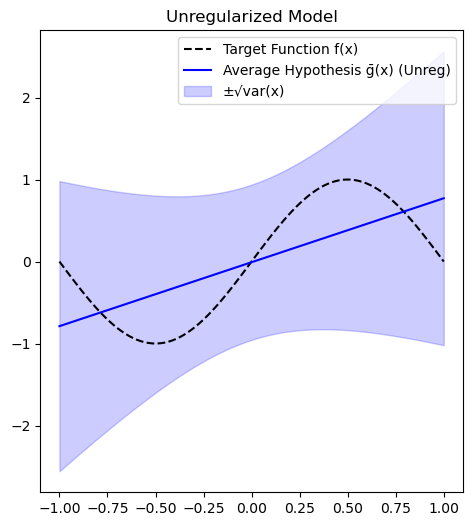

In [86]:
# Plot the models
plt.figure(figsize=(12, 6))

# Unregularized Model Plot
plt.subplot(1, 2, 1)
plt.plot(x_vals, target_function(x_vals), label="Target Function f(x)", color='black', linestyle='dashed')
plt.plot(x_vals, g_bar_unreg(x_vals), label="Average Hypothesis ḡ(x) (Unreg)", color='blue')
plt.fill_between(x_vals, g_bar_unreg(x_vals) - np.sqrt(variance_unreg), g_bar_unreg(x_vals) + np.sqrt(variance_unreg),
                 color='blue', alpha=0.2, label="±√var(x)")
plt.title("Unregularized Model")
plt.legend()

## Regularized Model Plot

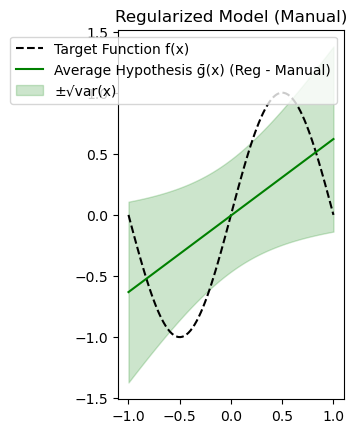

In [88]:
# Regularized Model Plot
plt.subplot(1, 2, 2)
plt.plot(x_vals, target_function(x_vals), label="Target Function f(x)", color='black', linestyle='dashed')
plt.plot(x_vals, g_bar_reg_alt(x_vals), label="Average Hypothesis ḡ(x) (Reg - Manual)", color='green')
plt.fill_between(x_vals, g_bar_reg_alt(x_vals) - np.sqrt(variance_reg_alt), g_bar_reg_alt(x_vals) + np.sqrt(variance_reg_alt),
                 color='green', alpha=0.2, label="±√var(x)")
plt.title("Regularized Model (Manual)")
plt.legend()

plt.show()

In [89]:
print("Unregularized Model Results:")
print(f"Average Hypothesis: ḡ(x) = {round(avg_m_unreg, 3)}x + {round(avg_b_unreg, 3)}")
print(f"Bias^2: {round(bias_sq_unreg, 3)}")
print(f"Variance: {round(np.mean(variance_unreg), 3)}")
print(f"Total Error: {round(total_error_unreg, 3)}")

print("\nAlternative Regularized Model Results:")
print(f"Average Hypothesis: ḡ(x) = {round(avg_m_reg_alt, 3)}x + {round(avg_b_reg_alt, 3)}")
print(f"Bias^2: {round(bias_sq_reg_alt, 3)}")
print(f"Variance: {round(np.mean(variance_reg_alt), 3)}")
print(f"Total Error: {round(total_error_reg_alt, 3)}")

Unregularized Model Results:
Average Hypothesis: ḡ(x) = 0.78x + -0.008
Bias^2: 0.211
Variance: 1.671
Total Error: 1.881

Alternative Regularized Model Results:
Average Hypothesis: ḡ(x) = 0.626x + -0.005
Bias^2: 0.234
Variance: 0.33
Total Error: 0.563


Based on Total error, I will choose regualrized model